# CV splitting by earthquake ID

This kernels implements a Cross Validation (CV) strategy that separates the segments in the training data by Earthquake ID.

For this, we first identify the earthquakes in the training dataset and we assign an unique ID to every earthquake (the earthquake #). Then we use the "Leave One Group Out cross-validator" to test a simple model. 

This kernel follows many of the suggestions in [this discussion](https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/78809) started by [Elliot](https://www.kaggle.com/tclf90).  

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import pywt
from sklearn.preprocessing import StandardScaler

## Global parameters

To save time and memory, this notebooks save the features, time_to_failure, and the earthquake ids in hdf files.
Hence, once the data was computed, it can be loaded from these files quickly.
The files are saved in the **alternate_input** directory.

In [2]:
compute_features = False 
# The computed features are saved in an hdf file along with the time_to_failure to 
# save the time spend reading the training data and the feature computation

if 'KAGGLE_URL_BASE' in os.environ:
    # If we are in a kaggle kernel, read from the csv file.
    train_data_format = 'csv'
else:
    # This only work in my local setup. 
    # Loading the training dataset from the feather file is much faster than CSV
    train_data_format = 'feather' 


## Load the data

In [3]:
def load_train_data(file_format):
    """Load the training dataset."""
    print(f"Loading data from {file_format} file:", end="")
    if file_format.lower() == 'feather':
        train_file_name = '../input/train_4mhz.feather'
        train_df = pd.read_feather(train_file_name)
    else:
        train_df = pd.read_csv('../input/train.csv', 
                               dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
    print("Done")
    return train_df

## Feature generator

In [4]:
sampling_frequency = 4e6 #4mhz
sampling_period = 1./sampling_frequency

def generate_features(segment_signal):
    
    segment_signal = segment_signal - segment_signal.mean()
    
    features = pd.Series()
    
    windows = 10
    signal_roll_std = segment_signal.rolling(windows).std().dropna().values
    features['std_roll_std_10'] = signal_roll_std.std()
    features['mean_roll_std_10'] = signal_roll_std.mean()
    features['q05_roll_std_10'] = np.quantile(signal_roll_std, 0.05)
    features['min_roll_std_10'] = signal_roll_std.min()
    features['q95_roll_std_10'] = np.quantile(signal_roll_std, 0.95)           
    
    return features

## Generate features

Here we will generate the features and also identify each segment with the corresponding earthquake that should be predicted by it. Each earthquake will be identified by an unique ID (earthquake #).

If **compute_features** is set to False, the features, time_to_failure, and the earthquake ids are loaded from the hdf files. Otherwise, they are computed and saved in hdf format for future use.

In [14]:
saved_files_present = ( os.path.isfile('../alternate_input/x_train.hdf') and 
                        os.path.isfile('../alternate_input/y_train.hdf') and 
                        os.path.isfile('../alternate_input/earthquakes_id.hdf') )

if (not compute_features) and saved_files_present:
    print("Reading hdf files:", end="")
    x_train = pd.read_hdf('../alternate_input/x_train.hdf','data')
    y_train = pd.read_hdf('../alternate_input/y_train.hdf','data')
    earthquakes_id = pd.read_hdf('../alternate_input/earthquakes_id.hdf','data')  
    print("Done")
    
else:    
        
    x_train = pd.DataFrame()
    earthquakes_id = pd.Series()
    y_train = pd.Series()
    
    train_df = load_train_data(train_data_format)    
    chunksize = 150_000

    segments = int(np.floor(train_df.shape[0] / chunksize))

    current_quake_id = 0
    last_time_to_failure = train_df.iloc[0]['time_to_failure']   
    
    print("Computing features:", end="")  
    sys.stdout.flush()
    for segment_number in tqdm(range(segments)):

        segment_df = train_df.iloc[segment_number*chunksize:
                                   segment_number*chunksize+chunksize]

        times_to_failure = segment_df['time_to_failure'].values

        # Ignore segments with an earthquake in it.
        if np.abs(times_to_failure[0]-times_to_failure[-1])>1:
            continue

        y_train.loc[segment_number] = times_to_failure[-1]

        features = generate_features(segment_df['acoustic_data'])
        x_train=x_train.append(features, ignore_index=True)    

        if np.abs(times_to_failure[-1]-last_time_to_failure)>1:
            current_quake_id += 1

        earthquakes_id.loc[segment_number] = current_quake_id
        last_time_to_failure = times_to_failure[-1]
    print("Done")
    
    print("Saving features, earthquake ids, and time_to_failure to hdf files:", end="")      
    if not os.path.isdir("../alternate_input"):
        os.makedirs("../alternate_input")
        
    x_train.to_hdf(f'../alternate_input/x_train.hdf','data')
    y_train.to_hdf('../alternate_input/y_train.hdf','data')
    earthquakes_id.to_hdf('../alternate_input/earthquakes_id.hdf','data')
    print("Done")
    
    del train_df

Reading hdf files:Done


In [15]:
np.unique(earthquakes_id)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

### Lets see how many earthquakes we have in the training set

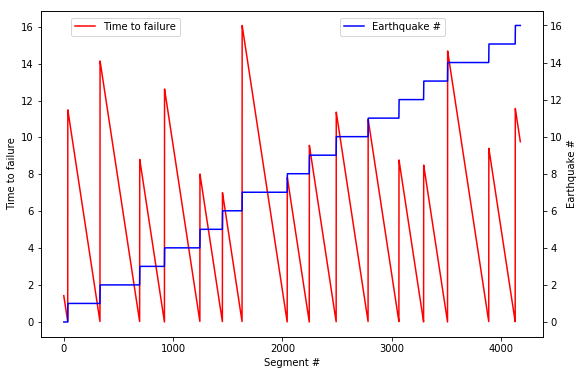

In [16]:
fig, ax1 = plt.subplots(figsize=(9,6))
ax1.plot(np.arange(y_train.size), y_train, color='r', label="Time to failure")
ax1.set_ylabel("Time to failure")
ax1.set_xlabel("Segment #")

ax2 = ax1.twinx() 
ax2.plot(np.arange(y_train.size), earthquakes_id, color='b', label="Earthquake #")
ax2.set_ylabel("Earthquake #")
ax1.legend(loc='center left', bbox_to_anchor=(0.05,0.95))
ax2.legend(loc='center', bbox_to_anchor=(0.7,0.95))
plt.show()


In the previous plot, we see that the Earthquake 0 and 16 only contain a small number of segments. Hence, during the the CV we will only use those segment for training but not for validation.

## Features correlations with Time_to_failure

Lets see how well the features are correlated with the time to failure.

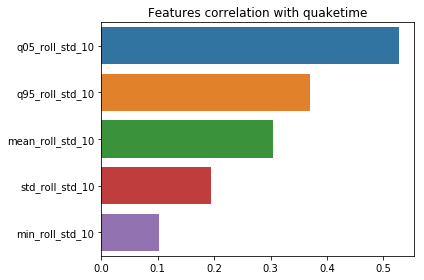

In [8]:
correlation_coefficients = np.abs(x_train.corrwith(y_train)).sort_values(ascending=False)

import seaborn as sns
sns.barplot(x=correlation_coefficients.values, y=correlation_coefficients.index)
plt.title('Features correlation with quaketime')
plt.tight_layout()

The q05, q95 quantiles have the best correlation with the time to failure, suggesting that they are very important features.

## Test model performance using a KFold validation strategy using the earthquakes IDs

### Define model

In [9]:
from catboost import CatBoostRegressor

# Fit the scaler for the data
scaler = StandardScaler()
scaler.fit(x_train)

def get_model():
    model = CatBoostRegressor(iterations=2000, 
                              loss_function='MAE', 
                              boosting_type='Plain')
    fit_kwargs = dict(silent=True)    
    return model, fit_kwargs    

### CV validation strategy


Following the discussions in https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/78809 we will use the LeaveOneGroupOut validation strategy.
- Use one earthquake for validation
- Use the rest for training

In [10]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import LeaveOneGroupOut

group_kfold = LeaveOneGroupOut()
fold_splitter = group_kfold.split(x_train, y_train, earthquakes_id)

train_errors = list()
validation_errors = list()
for group_out, (train_index, valid_index) in enumerate(fold_splitter):
    if group_out in [0,16]:
        continue
        
    print('Validation Earthquake:', group_out,end="   ")
    
    train_signal, validation_signal = x_train.iloc[train_index], x_train.iloc[valid_index]
    train_quaketime, validation_quaketime = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    train_signal = scaler.transform(train_signal)
    validation_signal = scaler.transform(validation_signal)    
            
    selected_model , fit_kwargs = get_model()
    selected_model.fit(train_signal, train_quaketime, **fit_kwargs)
    
    train_error = mean_absolute_error(selected_model.predict(train_signal), train_quaketime)
    validation_error = mean_absolute_error(selected_model.predict(validation_signal), validation_quaketime)
    print(f'train_error: {train_error:.2f}',end="  ")
    print(f'validation_error:{validation_error:.2f}', )
    
    train_errors.append(train_error)
    validation_errors.append(validation_error)
    
mean_train_error = np.asarray(train_errors).mean()
mean_validation_error = np.asarray(validation_errors).mean()

print(f"\nMean train_error: {mean_train_error:.2f}")
print(f"Mean validation_errors: {mean_validation_error:.2f}")

Validation Earthquake: 1   train_error: 1.97  validation_error:1.70
Validation Earthquake: 2   train_error: 1.86  validation_error:2.95
Validation Earthquake: 3   train_error: 1.97  validation_error:1.36
Validation Earthquake: 4   train_error: 1.93  validation_error:2.25
Validation Earthquake: 5   train_error: 1.91  validation_error:2.33
Validation Earthquake: 6   train_error: 1.92  validation_error:2.35
Validation Earthquake: 7   train_error: 1.74  validation_error:3.94
Validation Earthquake: 8   train_error: 1.90  validation_error:2.62
Validation Earthquake: 9   train_error: 1.99  validation_error:1.08
Validation Earthquake: 10   train_error: 1.98  validation_error:1.57
Validation Earthquake: 11   train_error: 1.98  validation_error:1.43
Validation Earthquake: 12   train_error: 1.96  validation_error:1.49
Validation Earthquake: 13   train_error: 1.94  validation_error:1.75
Validation Earthquake: 14   train_error: 1.79  validation_error:3.59
Validation Earthquake: 15   train_error: 1.

## Train the model using all the available data

In [11]:
# First we shuffle the data
from sklearn.utils import shuffle

shuffled_features = shuffle(x_train)
shuffled_quaketime = y_train.iloc[shuffled_features.index]
            
catboost_reg_model = CatBoostRegressor(iterations=1300, loss_function='MAE', boosting_type='Plain')
catboost_reg_model.fit(shuffled_features, shuffled_quaketime, silent=True)

In [12]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

quaketime_predict = catboost_reg_model.predict(x_train)

# create a new plot with a title and axis labels
p = figure(title="Time to failure prediction", x_axis_label='x', y_axis_label='y')

# add a line renderer with legend and line thickness
p.line (np.arange(quaketime_predict.shape[0]), quaketime_predict, line_color='red')

p.line (np.arange(y_train.values.shape[0]), y_train, line_color='blue')

# show the results
show(p)


Loading BokehJS ...

# Submit prediction

In [13]:
selected_model = catboost_reg_model

submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame()

for seg_id in submission.index:
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    ch = generate_features(seg['acoustic_data'])
    X_test = X_test.append(ch, ignore_index=True)

submission['time_to_failure'] = selected_model.predict(X_test).clip(0, 16)
submission.to_csv('submission.csv')   